In [3]:
using DiffEqJump, DiffEqBase, DiffEqBiological, DiffEqProblemLibrary, Plots
plotlyjs()

Plots.PlotlyJSBackend()

# Plot solutions by each method

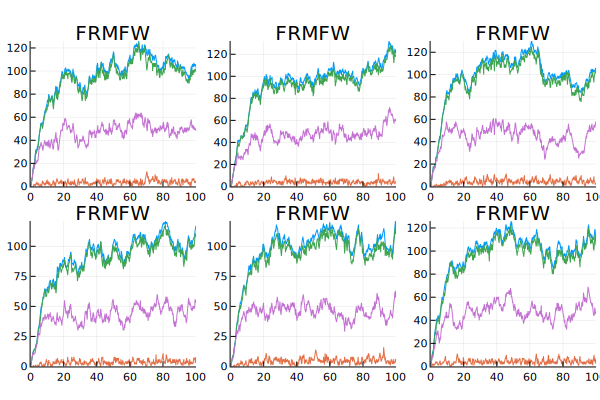

In [5]:
methods = (Direct(),DirectFW(),FRM(),FRMFW(),SortingDirect(),NRM())
legs    = [typeof(method) for method in methods]
shortlabels = [string(leg)[12:end] for leg in legs]
jprob   = prob_jump_multistate
prob    = jprob.discrete_prob
tf      = jprob.tstop
rn      = jprob.network
varlegs = ["A_P", "A_bound_P", "A_unbound_P", "RLA_P"]
varsyms = [
    [:S7,:S8,:S9], 
    [:S9],
    [:S7,:S8],
    [:S7]
]
varidxs = []
for vars in varsyms
    push!(varidxs, [findfirst(rn.syms, sym) for sym in vars])
end
p = []
for (i,method) in enumerate(methods)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    solv = zeros(1001,4)
    for (i,varidx) in enumerate(varidxs)
        solv[:,i] = sum(sol[varidx,:],1)
    end
    if i < length(methods)
        push!(p, plot(sol.t,solv,title=shortlabels[i],legend=false))
    else
        push!(p, plot(sol.t,solv,title=shortlabels[i],legend=true,labels=varlegs))
    end
end
plot(p...,format=:svg)

# Benchmarking performance of the methods

In [93]:
using BenchmarkTools
benchmarks = []
# turn off saving solution
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper())
    push!(benchmarks, @benchmark solve($jump_prob, $SSAStepper()))
end

In [94]:
medtimes = [median(b.times) for b in benchmarks]
bar(shortlabels,medtimes,title="median running time",leg=false)

In [95]:
relmed = medtimes / medtimes[1]
bar(shortlabels,relmed,title="median running time relative to Direct()",leg=false)